# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import progressbar
import timeit

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [3]:
content_articles_list = list(df_content['article_id'].unique())
df_articles_list = list(df['article_id'].unique())
total_articles_length = len(content_articles_list) + len(df_articles_list) - len(np.intersect1d(content_articles_list, df_articles_list))
print(total_articles_length)

1328


Text(0,0.5,'Views\n(log scale)')

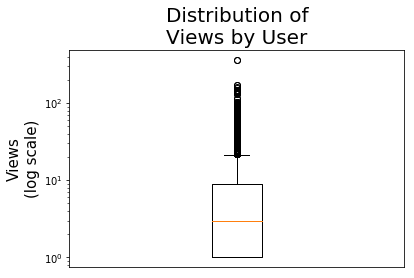

In [4]:
views_by_email = pd.value_counts(df['email'])
plt.boxplot(views_by_email.values)
plt.yscale('log')
plt.title('Distribution of\nViews by User', size = 20)
plt.xticks([])
plt.ylabel("Views\n(log scale)", size = 15)

In [5]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [6]:
df_content.doc_status.value_counts()

Live    1056
Name: doc_status, dtype: int64

In [7]:
df_content_duplicates = df_content.drop(['article_id'], axis = 1)
df_content_duplicates.duplicated().value_counts()

False    1056
dtype: int64

In [8]:
print(len(df_content))
print(df_content.duplicated().value_counts())
print(df.duplicated().value_counts())

1056
False    1056
dtype: int64
False    33682
True     12311
dtype: int64


Although df_content likely has no exact duplicates, df has many where the same user was looking at the same article.

In [9]:
print(df_content.isnull().sum())
print()
print(df.isnull().sum())

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

article_id     0
title          0
email         17
dtype: int64


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [10]:
df_dict = df.groupby(['email', 'article_id']).count()

unique_users = list(df['email'].unique())
print("{} unique user emails".format(len(unique_users)))
articles_per_user = {}

for user in unique_users:    
    if user not in articles_per_user:
        articles_per_user[user] = {}

# Create the progressbar
cnter = 0
bar = progressbar.ProgressBar(maxval=len(df_dict)+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

bar.start()
for i in df_dict.iterrows():
    
    # Update the progress bar
    cnter+=1 
    bar.update(cnter)
    
    articles_per_user[i[0][0]][int(i[0][1])] = int(i[1])
    
bar.finish()

5149 unique user emails


[========================================================================] 100%


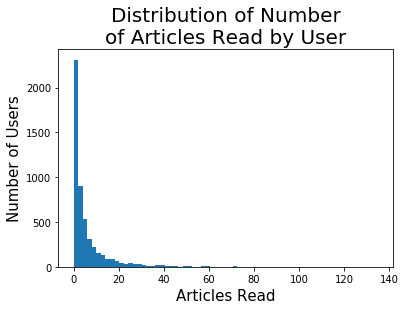

In [11]:
articles_read = [len(articles_per_user[x]) for x in articles_per_user]  
plt.hist(articles_read, bins = 'scott')
plt.title("Distribution of Number\nof Articles Read by User", size = 20)
plt.xlabel("Articles Read", size = 15)
plt.ylabel("Number of Users", size = 15)
plt.show()

In [12]:
stats.describe(articles_read)

DescribeResult(nobs=5149, minmax=(0, 135), mean=6.5389395999223154, variance=99.802533529567896, skewness=4.221543181256095, kurtosis=27.59368698035452)

In [13]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(articles_read)
max_views_by_user = df['email'].value_counts().max()
print("Median Value: {}\nMaximum Views by User: {}".format(median_val, max_views_by_user))

Median Value: 3.0
Maximum Views by User: 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [14]:
# Find how many field sare duplicated in each feature
doc_body_duplicates = df_content_duplicates['doc_body'].duplicated().value_counts()
doc_description_duplicates = df_content_duplicates['doc_description'].duplicated().value_counts()
doc_full_name_duplicates = df_content_duplicates['doc_full_name'].duplicated().value_counts()

print("Duplicates by feature:\n\ndoc_body: {}\ndoc_description: {}\ndoc_full_name: {}".format(doc_body_duplicates[1],
                                                                                             doc_description_duplicates[1],
                                                                                             doc_full_name_duplicates[1]))


Duplicates by feature:

doc_body: 19
doc_description: 33
doc_full_name: 5


In [15]:
# Explore repeated doc bodies
df2 = df_content[df_content.duplicated(['doc_body'],keep=False)]
df2.sort_values('doc_body') 

,doc_body,doc_description,doc_full_name,doc_status,article_id
244,* Select a country/region: United States\r\n\r...,"Data exploration and analysis is a repetitive,...",Notebooks: A power tool for data scientists,Live,244
474,* Select a country/region: United States\r\n\r...,Machine learning is changing not only how we ...,Intelligent applications - Apache Spark,Live,473
564,Cheat sheet,The RStudio IDE is the most popular integrated...,RStudio IDE Cheat Sheet,Live,563
678,Cheat sheet,The devtools package makes it easy to build yo...,Package Development with devtools Cheat Sheet,Live,677
892,Need to report the video?\r\n\r\nSign in to re...,Video tutorial showing the complete creation o...,Mobile App Webinar Demo,Live,889
997,Need to report the video?\r\n\r\nSign in to re...,Using Cloudant and MobileFirst services on Blu...,Building a MobileFirst App on IBM Bluemix,Live,992
33,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,Analytics and visualization often go hand-in-h...,Using Brunel in IPython/Jupyter Notebooks,Live,33
369,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,After shoveling the driveway several times and...,Snowzilla!,Live,368
885,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,How to create a blog entry using Brunel in a f...,Blogging With Brunel,Live,882
1020,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,The two main new features of Brunel 0.8 are an...,Enhanced Color mapping,Live,1015


Although some doc bodies are repeated, the descriptions, full names, and ids are unique.  These could be errors, or else videos or pictures that are different but have identical text fields.  I should keep these "duplicates."

In [16]:
# explore repeated doc descriptions
df2 = df_content[df_content.duplicated(['doc_description'],keep=False)]
df2.sort_values('doc_description')

,doc_body,doc_description,doc_full_name,doc_status,article_id
884,* Home\r\n * Research\r\n * Partnerships and C...,"Every two weeks, we find the most interesting ...",Web Picks (week of 2 October 2017),Live,881
607,* Home\r\n * Research\r\n * Partnerships and C...,"Every two weeks, we find the most interesting ...",Web Picks (December 2017),Live,606
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
560,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 4, 2017)",Live,559
304,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (August 30, 2016)",Live,304
288,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (January 31, 2017)",Live,288
727,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (March 7, 2017)",Live,725
210,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (February 14, 2017)",Live,210
191,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (March 28, 2017)",Live,191
839,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (October 05, 2016)",Live,836


A majority of repeats seem to be periodicals, which unsurprisingly may have the same or similar titles and descriptions, but likely unique content. Some articles have the same id, and likely truly are repeats, and can be dropped in the next step below, where we find and deal with repeat ids. NaN's likely aren't repeats, but for ease of analysis later, we'll replace their `doc_description` with a copy of their `doc_full_name`. For NLP purposes, this seems like a resonable decision. 907, 835, 893, 161, 800, 1035, 252, and 492 deserve a closer look to see if they're repeats and should be combined.

In [17]:
# find indices of nulls
idx = df_content.index[df_content['doc_description'].isnull()].tolist()
print(idx)

[354, 768, 919]


In [18]:
# Replace nulls with doc full_title
for x in idx:
    df_content.at[x, 'doc_description'] = df_content.at[x, 'doc_full_name']

In [19]:
# Check that nulls have been taken care of
print(len(df2))
df2 = df_content[df_content.duplicated(['doc_description'],keep=False)]
print(len(df2))

43
40


In [20]:
potential_drops = [907, 835, 893, 161, 800, 1035, 252, 492]

counter = 0
for x in df_content[df_content['article_id'].isin(potential_drops)].sort_values('doc_description')['doc_body']:
    print("\n_________________________\n{}".format(potential_drops[counter]))
    print(x[:500])
    counter += 1


_________________________
907
Skip to main content IBM developerWorks / Developer Centers Sign In | Register Cloud Data Services * Services * How-Tos * Blog * Events * ConnectCONTENTS * IBM Analytics for Apache Spark * Get Started * Get started in Bluemix       * Build SQL Queries       * Use the Machine Learning Library       * Load and Analyze dashDB data with Apache Spark                * Tutorials and samples * Start Developing with Notebooks       * Sentiment Analysis of Twitter Hashtags       * Sample Notebooks        

_________________________
835
Skip to main content IBM developerWorks / Developer Centers Sign In | Register Cloud Data Services * Services * How-Tos * Blog * Events * ConnectCONTENTS * Apache Spark * Get Started * Get Started in Bluemix                * Tutorials * Load dashDB Data with Apache Spark       * Load Cloudant Data in Apache Spark Using a Python Notebook       * Load Cloudant Data in Apache Spark Using a Scala Notebook       * Build SQL Queries       

The content of the first two pairs appears to be different, although the content of 800 and 1035 appear identical and should be combined. On further scrutiny, 252 and 492 appear different as well, as one is dated to 9 September and one to 2 July, and appear to be periodicals.

In [21]:
# Check 252 and 492
for x in df_content[df_content['article_id'].isin([252, 492])].sort_values('doc_description')['doc_body']:
    print(x[641:730])



WEB PICKS (WEEK OF 4 SEPTEMBER 2017)
Posted on September 9, 2017Every two weeks, we 


WEB PICKS (WEEK OF 26 JUNE 2017)
Posted on July 2, 2017Every two weeks, we find the 


In [22]:
# drop 1035 from df_content
idx2 = df_content.index[df_content['article_id'] == 1035].tolist()
df_content = df_content.drop(idx2)

# Replace 1035 reads with 800 reads in df
idx3 = df.index[df['article_id'] == 1035].tolist()
for x in idx3:
    df.at[x, 'article_id'] = 800

In [23]:
# examine duplicates in full_name
df2 = df_content[df_content.duplicated(['doc_full_name'],keep=False)]
df2.sort_values('doc_full_name')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398


These have repeat article IDs and will be dropped below

In [24]:
# Remove any rows that have the same article_id - only keep the first

In [25]:
# drop articles with duplicate ids in df_content
print(df_content['article_id'].duplicated().sum())
df_content = df_content.drop_duplicates(subset = 'article_id')
print(df_content['article_id'].duplicated().sum())

5
0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [26]:
# answer a + 1 to adjust for earlier data cleaning
num_articles_user = len(df['article_id'].unique()) +1
# answer b + 1 to adjust for earlier data cleaning
num_articles_total = len(df_content['article_id'].unique()) + 1
# answer c - 1 to adjust for earlier data cleaning
num_users = len(df['email'].unique()) - 1
# answer d
num_interactions = len(df)

print(num_articles_user, num_articles_total, num_users, num_interactions)

714 1051 5148 45993


In [27]:
unique_articles = num_articles_user # The number of unique articles that have at least one interaction
total_articles = num_articles_total # The number of unique articles on the IBM platform
unique_users = num_users # The number of unique users
user_article_interactions = num_interactions # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [28]:
id_counts = df['article_id'].value_counts()
print("Most-viewed article: {}\nView counts: {}".format(id_counts.idxmax(), id_counts.max()))

Most-viewed article: 1429.0
View counts: 937


In [29]:
most_viewed_article_id = str(id_counts.idxmax())# The most viewed article in the dataset as a string with one value following the decimal 
max_views = id_counts.max()# The most viewed article in the dataset was viewed how many times?

In [30]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [31]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [39]:
def top_items_func(n, df, column):
    """
    Helper function returning the top articles in a column of a dataframe.
    
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook
    column - (string) column name for which to find top items
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' items 
    """
    top_articles = df[column].value_counts().index[:n]
    return top_articles
    
# NOTE: These 3 could be combined into one function, with an argument for which column to process,
# which could reduce this to three lines of code. But in keeping with the notebook's original documentation 
# asking for 2 equations with these specific names, I've split the function into 3 and tried to follow 
# DRY to the best of my abilities.
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    return top_items_func(n, df, 'title')

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    return top_items_func(n, df, 'article_id')

In [40]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object')
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')


In [41]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [42]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_by_article = df.groupby(['user_id', 'article_id']).any().unstack().fillna(0.0)
    user_item = np.matrix(user_by_article).astype(int)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [43]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."

'''
I'm changing the shape check on rows from 714 to 713. 

I strongly believe the contents of 800 and 1035 are two copies of an identical blog posting, 
and for recommendation purposes should be considered the same article, which is why I combined them 
earlier in the dataframe.

I'm open to arguments otherwise, but believe we should be encouraged as junior data scientists
to develop and use our intuition in data munging, especially on judgement calls as to whether two
apparently identical or very similar articles should be considered two separate posts with lower readership
or one post with larger readership.
'''

assert user_item.shape[1] == 713, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert int(user_item.sum(axis=1)[0]) == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [44]:
# List of unique user ids corresponding to matrix rows
userids = list(df['user_id'].unique())

def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    similarities = []
    most_similar_users = []
    # compute similarity of each user to the provided user
    for row in user_item:
        similarities.append(int(np.dot(row, user_item[int(user_id-1)].T)))
    similarities = list(zip(similarities, userids))
    # sort by similarity
    similarities.sort(reverse=True)
    # create list of just the ids
    for first, last in similarities:
        most_similar_users.append(last)
    # remove the own user's id
    most_similar_users.remove(user_id)   
    return most_similar_users # return a list of the users in order from most to least similar
        

In [45]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 4459, 203, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 3782, 23, 4459, 203]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [46]:
article_list = np.sort(df.article_id.unique())

def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    for id in article_ids:
        article_names.append(list(df.loc[df['article_id'] == float(id)]['title'])[0])
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    user_idx = int(user_id-1)
    article_idx = np.where(user_item[user_idx])[1]
    article_ids = np.sort(df.article_id.unique())[article_idx]
    article_names = get_article_names(article_ids)
    article_ids = [str(x) for x in article_ids]
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    articles_read = get_user_articles(user_id)
    closest_users = find_similar_users(user_id)
    
    recs = np.array([])
    
    for user in closest_users:
        sim_articles = get_user_articles(user)
        new_recs = np.setdiff1d(sim_articles, articles_read, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        if len(recs) > m-1:
            break
        recs = get_article_names(recs)
    
    return recs # return your recommendations for this user_id    

In [47]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [48]:
def compute_euclidean_dist(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the euclidean distance between user1 and user2
    '''
    # Pull movies for each user
    arr1 = user_item[int(user1)-1]
    arr2 = user_item[int(user2)-1]
    dist = np.linalg.norm(arr1 - arr2)
    
    return dist #return the euclidean distance

In [49]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbors_dict = {'neighbor_id':{}, 'similarity': {}, 'num_interactions': {}}  
    for i, user in enumerate(find_similar_users(user_id)):
        neighbors_dict['neighbor_id'][i] = user
        neighbors_dict['similarity'][i] = compute_euclidean_dist(user_id, user)
        neighbors_dict['num_interactions'][i] = (user_item[user-1]).sum()
    neighbors_df = pd.DataFrame.from_dict(neighbors_dict) 
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = np.array([])
    articles_read = get_user_articles(user_id)
    closest_users = list(get_top_sorted_users(user_id)['neighbor_id'])
    for user in closest_users:
        sim_articles = get_user_articles(user)
        new_recs = np.setdiff1d(sim_articles, articles_read, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        if len(recs) > m-1:
            break
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [50]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1000.0' '1014.0' '1025.0' '1051.0' '1052.0' '108.0' '109.0' '1101.0'
 '1148.0' '1159.0']

The top 10 recommendations for user 20 are the following article names:
['recommender systems: approaches & algorithms', '1448    i ranked every intro to data science course on...\nName: title, dtype: object', 'data tidying in data science experience', 'a tensorflow regression model to predict house values', 'access db2 warehouse on cloud and db2 with python', '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object', 'tensorflow quick tips', 'airbnb data for analytics: mallorca reviews', 'airbnb data for analytics: vancouver listings', 'analyze facebook data using ibm watson and watson studio']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [51]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0]# Find the user that is most similar to user 1 
"""

NOTE: The 10th-most similar user should be index 9, not 10. I think this may be an error in Udacity's test file, 
where index 10 instead of index 9 corresponds to the answer Udacity is seeking.

"""
user131_10th_sim = find_similar_users(131)[10]# Find the 10th most similar user to user 131

In [52]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

print(sol_5_dict)

t.sol_5_test(sol_5_dict)

{'The user that is most similar to user 1.': 3933, 'The user that is the 10th most similar to user 131': 242}
This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.** *With a brand-new user, `get_top_articles` would probably be the most practical way to make recommendations, as we'd have no history of read articles to use for comparisons with other users. A better way to make recommendations could be asking a user what topics they're interested in and recommending the top articles in each of those categories, or else recommending the top n articles in each possible category to expose users to a wide range of topics and build future recommendations from the user's interactions with this first batch.*

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [53]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(x) for x in get_top_article_ids(10)]# Your recommendations here

In [54]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [56]:
all_titles = df['title'].unique()

def titles_to_ids(titles):
    # make rec_ids list
    ids = []
    for item in titles:
        item_id = list(df.loc[df['title'] == item]['article_id'])[0]
        ids.append(item_id)        
    return ids

def find_cosine_sim(long_title):
    # create an array of all dataset titles plus the concatenated titles from user's reading history 
    tfidf_arr = np.append(long_title, all_titles)
    
    # instantitate a Tf-idf instance
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')

    # find cosine similarities of titles to each other and to the user's reading history
    tfidf_matrix = tf.fit_transform(tfidf_arr)
    cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
    
    return cosine_similarities

def make_recs_title_list(cosine_similarities):
    # instatiate an empty recs list
    recs = []
    
    # create list of tuples between cosine similarities and titles, excluding the user's concatenated title history
    similar_list = list(zip(cosine_similarities[0][1:], all_titles))

    # sort the list 
    rec_list = sorted(similar_list, reverse=True)

    # create list of just titles most similar to user's history
    for first, last in rec_list:
        recs.append(last)
        
    return recs
    


def make_content_recs(user_id, m=10):
    '''
    This function takes in a user's reading history, and based off of all of the titles, 
    finds articles with a similar Tf-idf score.
    
    INPUT:
        user_id - str: ID of the user for which you'll be making content-based recommendations
        m - int: How many recommendations you'd like to make
    
    OUTPUT:
        rec_ids - arr: list of recommended articles by id
        rec_names - arr: list of recommended articles by title
    '''
    # handle users with no history
    if user_id not in df['user_id']:
        rec_names = get_top_articles(m)
        rec_ids = get_top_article_ids(m)
    
    else:
        # concatenate the titles from all articles read by the user into a string
        user_articles = get_user_articles(user_id)[1]
        concat_titles = ' '.join(user_articles)
        
        # create list of cosine similarities with other articles
        find_cosine_sim(concat_titles)

        # create a list of recommended articles by title
        make_recs_title_list(cosine_similarities)

        # remove articles the user's already read
        recs = np.setdiff1d(recs, user_articles, assume_unique=True)

        # make recs list
        rec_names = recs[:m]

        # make rec_ids list        
        rec_ids = titles_to_ids(rec_names)
        
    return rec_names, rec_ids

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.** 

If a user does not have a history with us, I once again recommend the most popular n articles, as above. I could alternately use Tf-idf to find 5 latent categories within the articles and return the most popular, say, 2 articles in each category. 

If a user does have a reading history, I concatenate all the titles of the articles they've read into a "supertitle", then make a Tf-idf matrix between this supertitle and all other article titles. I return a list of the most highly-scored titles for similarity, remove articles the user had already read, then return the top n titles and their indices.  The idea is that an article containing similar material to the totality of what the user has read may be of interest to the individual.

Going forward, this could be weighted by article popularity (say, if an article is rarely read and therefore potentially uninteresting, we may not wat to recommend it) for better recommendations.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [57]:
# make recommendations for a brand new user
make_content_recs('5150.0')
print(f"Rec names: {rec_names}\n\nRec IDs: {rec_ids}")

# make a recommendations for a user who only has interacted with article id '1427.0'
print(f"\n\n\nArticle title: {get_article_names(['1427.0'])}\n")
recs = make_recs_title_list(find_cosine_sim(get_article_names(['1427.0'])))
recs = np.setdiff1d(recs, get_article_names(['1427.0']), assume_unique=True)
rec_names = recs[:10]
rec_ids = titles_to_ids(rec_names)
print(f"Rec names: {rec_names}\n\nRec IDs: {rec_ids}")

Rec names: ['recommender systems: approaches & algorithms', '1448    i ranked every intro to data science course on...\nName: title, dtype: object', 'data tidying in data science experience', 'a tensorflow regression model to predict house values', 'access db2 warehouse on cloud and db2 with python', '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object', 'tensorflow quick tips', 'airbnb data for analytics: mallorca reviews', 'airbnb data for analytics: vancouver listings', 'analyze facebook data using ibm watson and watson studio']

Rec IDs: ['1000.0' '1014.0' '1025.0' '1051.0' '1052.0' '108.0' '109.0' '1101.0'
 '1148.0' '1159.0']



Article title: ['use xgboost, scikit-learn & ibm watson machine learning apis']

Rec names: ['ibm watson machine learning: get started'
 'python machine learning: scikit-learn tutorial'
 'watson machine learning for developers' 'what is machine learning?'
 'machine learning for everyone'
 'create a project for watson machin

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [58]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [59]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [60]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)# use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.** *for one, we're not using a subset, which makes our matrices much larger. We may want to truncate our number of latent features for more efficient computation. SVD, unlike the original user-item matrix, also pulls out latent features for each user and article, which helps us better understand the relationships between users and articles as well as the likely relationships between user and articles that have not yet interacted. This is different from the original matrix, which can only use existing interactions to find similar users or items and make recommendations.*

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

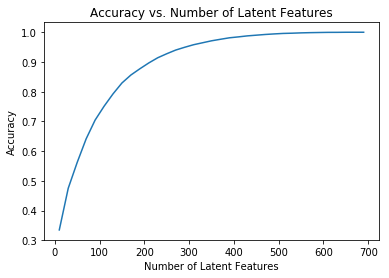

In [61]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [62]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    '''
    train_user_item = train_df[['user_id', 'movie_id', 'rating', 'timestamp']]
    train_data_df = train_user_item.groupby(['user_id', 'movie_id'])['rating'].max().unstack()
    '''
    user_item_train = np.matrix(df_train.groupby(['user_id', 'article_id']).any().unstack().fillna(0.0)).astype(int)
    user_item_test = np.matrix(df_test.groupby(['user_id', 'article_id']).any().unstack().fillna(0.0)).astype(int)

    
    test_idx = list(df_test['user_id'])
    test_arts = list(df_test['article_id'])
    train_idx = list(df_train['user_id'])
    train_arts = list(df_train['article_id'])
    
    return user_item_train, user_item_test, test_idx, test_arts, train_idx, train_arts

user_item_train, user_item_test, test_idx, test_arts, train_idx, train_arts = create_test_and_train_user_item(df_train, df_test)

In [64]:
len_test_users = len(np.unique(test_idx))
len_test_arts = len(np.unique(test_arts))
users_overlap = len(np.intersect1d(test_idx, train_idx))
arts_overlap = len(np.intersect1d(test_arts, train_arts))

print(f"How many users can we make predictions for in the test set?: {users_overlap}")
print(f"How many users in the test set are we not able to make predictions for because of the cold start problem? {len_test_users - users_overlap}")
print(f"How many movies can we make predictions for in the test set?: {arts_overlap}")
print(f"How many movies in the test set are we not able to make predictions for because of the cold start problem?{len_test_arts - arts_overlap}")

How many users can we make predictions for in the test set?: 20
How many users in the test set are we not able to make predictions for because of the cold start problem? 662
How many movies can we make predictions for in the test set?: 574
How many movies in the test set are we not able to make predictions for because of the cold start problem?0


In [65]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [66]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)# fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (713,), (713, 713))

In [67]:
users_in_common = list(np.intersect1d(train_idx, test_idx))
print(f"Users in both training and testing sets: {users_in_common}")

Users in both training and testing sets: [2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968, 3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487]


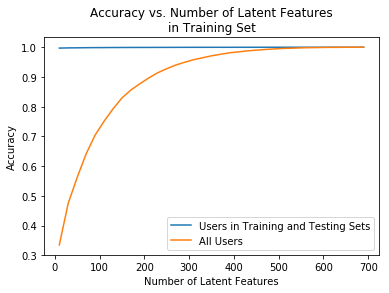

In [87]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs2 = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    #compute accuracy only for rows in common between training and testing
    diffs2=[]
    for idx in users_in_common:
        # compute error for each prediction to actual value
        diff2 = np.subtract(user_item_matrix.iloc[idx], user_item_est[idx])
        diffs2.append(diff2)
    
    # total errors and keep track of them
    err2 = np.sum(np.sum(np.abs(diffs2)))
    sum_errs2.append(err2)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs2)/df.shape[0], label = 'Users in Training and Testing Sets');
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0], label = 'All Users');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.legend();
plt.title('Accuracy vs. Number of Latent Features\nin Training Set');

Plotting the accuracy vs. number of training features for the whole training set vs just the rows in common between trainging and testing we see that the accuracy in the latter is much more accurate right off the bat, which could be indicative of overfitting due to the small size of training samples. A better comparison could be the same users in the training and testing sets.

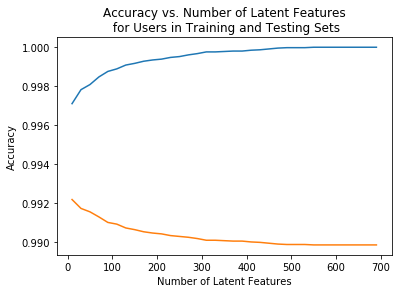

In [88]:
num_latent_feats2 = np.arange(2,100,2)

sum_errs3 = []
for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    #compute accuracy only for rows in common between training and testing
    diffs3=[]
    for idx in users_in_common:
        
        index = list(np.unique(test_idx)).index(idx)
        matrix_row = user_item_matrix.iloc[index]

        # compute error for each prediction to actual value
        diff3 = np.subtract(matrix_row, user_item_est[idx])
        diffs3.append(diff3)
    
    # total errors and keep track of them
    err3 = np.sum(np.sum(np.abs(diffs3)))
    sum_errs3.append(err3)

plt.plot(num_latent_feats, 1 - np.array(sum_errs2)/df.shape[0]);
plt.plot(num_latent_feats, 1 - np.array(sum_errs3)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features\n for Users in Training and Testing Sets');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.** Accuracy is very high right off the bat, likely because we're comparing such as small number of users. As accuracy on the testing set is decreasing right from the beginning, we likely have overfitting and should stick to a minimal number of features, say 2 or 3, or use the more comprehensive latent features matrix dI'd proceed with 2 latest features. A good baseline model could just be our first "top articles" model, and other models could be compared against this to see whether our recommendations are better than blind recommendations.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])